C:\Users\User\AppData\Local\Temp\ipykernel_34548\925532589.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Running Iterations: 100%|██████████| 50/50 [45:24<00:00, 54.49s/it]

Custom KModes Average Accuracy : 0.8770212765957447
Custom KModes Average Rand Index : 0.8224316950349326
Custom KModes Standard Deviation of Accuracy : 0.11025219043492701
Custom KModes Standard Deviation of rand index 0.16823126207699152
KModes SKLearn Average Accuracy: 0.8885106382978725
KModes SKLearn Average Rand Index: 0.8189266022939938
KModes SKLearn Standard Deviation of Accuracy: 0.1032351300568914


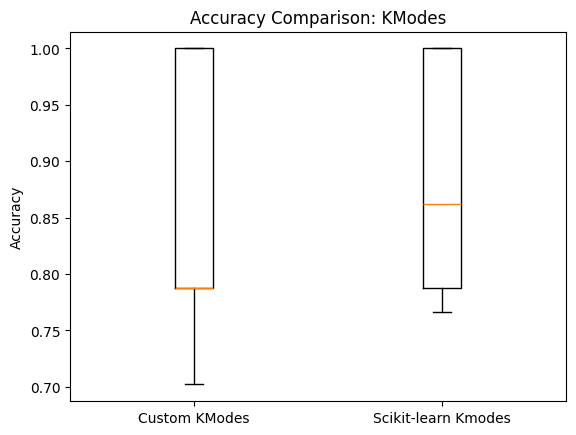

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from kmodes.kmodes import KModes
from sklearn.metrics import accuracy_score, adjusted_rand_score
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

def initialize_centroids(data, k):
    centroids = data.sample(k).values
    return centroids

def calculate_distance(x, centroids):
    distances = np.zeros(len(centroids))
    for i, centroid in enumerate(centroids):
        distances[i] = np.sum(x != centroid)
        
    return distances

def assign_clusters(data, centroids):
    distances = np.apply_along_axis(calculate_distance, 1, data.values, centroids)
    clusters = np.argmin(distances, axis=1)
    return clusters

def update_centroids(data, clusters, k):
    centroids = np.zeros((k, data.shape[1]))

    for i in range(k):
        cluster_instances = data[clusters == i]

        if not cluster_instances.empty:
            for j in range(data.shape[1]):
                mode_values = cluster_instances.iloc[:, j].mode()
                if not mode_values.empty:
                    centroids[i, j] = mode_values.values[0]

    return centroids

def kmodes_plus(data, k, num_iterations=50):
    for _ in tqdm(range(num_iterations), desc="Running Iterations", leave=False):
        centroids = initialize_centroids(data, k)

        for _ in range(50):
            clusters = assign_clusters(data, centroids)
            centroids = update_centroids(data, clusters, k)
    return clusters, centroids

def align_clusters(clusters, true_labels):
    unique_clusters = np.unique(clusters)
    aligned_clusters = np.zeros_like(clusters)
    for cluster in unique_clusters:
        true_label = pd.Series(true_labels[clusters == cluster]).mode()[0]
        aligned_clusters[clusters == cluster] = true_label
    return aligned_clusters

def preprocess_data(dataset):
    # We convert categorical columns to numeric using one-hot encoding
    dataset_encoded = pd.get_dummies(dataset)
    # we convert all columns to numeric to handle any remaining non-numeric values
    dataset_encoded = dataset_encoded.apply(pd.to_numeric, errors='coerce')
    dataset_encoded = dataset_encoded.dropna()
    
    return dataset_encoded

dataset = pd.read_csv('soybean-small.data', sep=',', header=None)

# Encoding the true labels
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(dataset.iloc[:, -1])

# Retrieving the original label mapping
original_labels = label_encoder.inverse_transform(np.unique(true_labels_encoded))

# Preprocess the dataset
dataset_processed = preprocess_data(dataset)
num_iterations = 50
accuracy_results = []
rand_index_results = []
sklearn_accuracy_results = []
sklearn_rand_index_results = []

for _ in tqdm(range(num_iterations), desc="Running Iterations"):
    # Using my custom kmodes_plus
    clusters, _ = kmodes_plus(dataset_processed, k=4, num_iterations=50)
    aligned_clusters = align_clusters(clusters, true_labels_encoded)
    custaccuracy = accuracy_score(true_labels_encoded, aligned_clusters)
    cust_rand_index = adjusted_rand_score(true_labels_encoded, aligned_clusters)
    accuracy_results.append(custaccuracy)
    rand_index_results.append(cust_rand_index)

    # Using kmodes library
    kmodes_model = KModes(n_clusters=4, init='Huang', n_init=1, verbose=0)
    kmodes_clusters = kmodes_model.fit_predict(dataset_processed.iloc[:, :-1])
    sklearn_aligned_clusters = align_clusters(kmodes_clusters, true_labels_encoded)
    sklearnaccuracy = accuracy_score(true_labels_encoded, sklearn_aligned_clusters)
    sklearn_rand_index = adjusted_rand_score(true_labels_encoded, sklearn_aligned_clusters)
    sklearn_accuracy_results.append(sklearnaccuracy)
    sklearn_rand_index_results.append(sklearn_rand_index)

avg_custom_accuracy = np.mean(accuracy_results)
avg_custom_randindex = np.mean(rand_index_results)
std_acc_score = np.std(accuracy_results)
print("Custom KModes Average Accuracy :", avg_custom_accuracy)
print("Custom KModes Average Rand Index :", avg_custom_randindex)
print("Custom KModes Standard Deviation of Accuracy :", std_acc_score)
print("Custom KModes Standard Deviation of rand index", np.std(rand_index_results))
sklearn_avg_accuracy = np.mean(sklearn_accuracy_results)
sklearn_avg_rand_index = np.mean(sklearn_rand_index_results)
print("KModes SKLearn Average Accuracy:", sklearn_avg_accuracy)
print("KModes SKLearn Average Rand Index:", sklearn_avg_rand_index)
print("KModes SKLearn Standard Deviation of Accuracy:", np.std(sklearn_accuracy_results))
plt.boxplot([accuracy_results, sklearn_accuracy_results], labels=['Custom KModes', 'Scikit-learn Kmodes'])
plt.title('Accuracy Comparison: KModes')
plt.ylabel('Accuracy')
plt.show()